In [1]:
import gym
import seagul.envs
gym.make('su_acro_drake-v0')

import pickle
import torch.utils.data

from seagul.rl.run_utils import load_model, load_workspace
import numpy as np
from numpy import pi
import matplotlib.pyplot as plt
from pprint import pprint
import pandas as pd
from seagul.rl.models import PPOModel, SwitchedPPOModel, SwitchedPPOModelActHold
from seagul.nn import MLP
#torch.set_default_dtype(torch.double)
dtype = np.float32


#seeds = [1]; load_paths =  ['./data2/drake_double/dynamic_step' + str(seed) for seed in seeds]
#load_paths =  ['./data2/sac/asdasdasd']
load_paths = ['/home/sgillen/work/seagul/seagul/notebooks/switching/data/data2/fixed_step/ppo_comp']
#seeds = [0]; load_paths = ['./data/drake_acro_final/warm_seed' + str(seed) for seed in seeds]
model, env, args, ws = load_workspace(load_paths[0])
#num_steps = ws['num_epochs']
#num_steps = 1000



/home/sgillen/work/seagul/seagul/envs/__init__.py:77: UserWarning: Warning, registering environments for rllib failed!
  warnings.warn("Warning, registering environments for rllib failed!")
/home/sgillen/miniconda3/envs/drake/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sgillen/miniconda3/envs/drake/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sgillen/miniconda3/envs/drake/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type i

Logging to /tmp/openai-2020-01-23-16-23-36-075494


/home/sgillen/miniconda3/envs/drake/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:541: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/sgillen/miniconda3/envs/drake/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:542: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/sgillen/miniconda3/envs/drake/lib/python3.6/site-packages/tensorboard/compat/tensorflow_stub/dtypes.py:543: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/sgillen/minicond

seagul.rl.run_utils
seagul.rl.run_utils


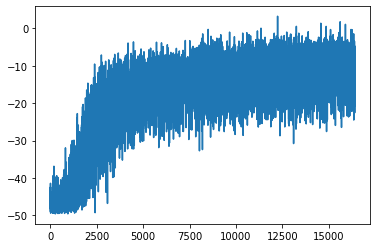

In [2]:
plt.plot(ws['raw_rew_hist'])

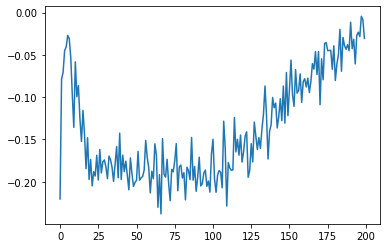

In [3]:
plt.plot(ws['pol_loss_hist'])

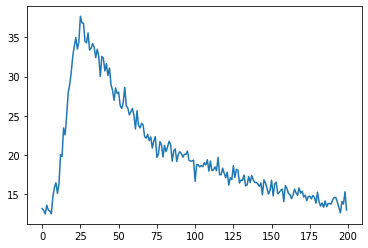

In [4]:
plt.plot(ws['val_loss_hist'])

In [9]:
torch.save(model.value_fn, open('ppo2_warm_val','wb'))
torch.save(model.policy, open('ppo2_warm_pol','wb'))

In [ ]:
model.value_fn.state_dict()

In [5]:
from seagul.nn import DummyNet

# Acrobot
#load_path = './data/drake_acro4/seed7'
load_path = load_paths[0]
model, env, args, ws = load_workspace(load_path)
#model.policy = DummyNet(4,1,0,0,0)
model.env = env
myenv = env
#myenv.num_steps=1000
#myenv.max_t = 5


#model.gate_fn.net_fn = gate
action_hist = np.zeros((myenv.num_steps,1))
state_hist = np.zeros((myenv.num_steps, myenv.observation_space.shape[0]))
reward_hist = np.zeros((myenv.num_steps, 1))
logp_hist = np.zeros((myenv.num_steps, 1))
gate_mean = np.zeros((myenv.num_steps,1))

#model.action_var = 0
#model.action_var = 1
#model.gate_var = 0

#model.action_var = 0
obs = myenv.reset()

for i in range(myenv.num_steps):
        obs = torch.as_tensor(obs, dtype=torch.float32).reshape(1,-1)
        actions, _, _, logp = model.step(obs)
        actions = actions.detach()
        #actions = np.clip(actions, -700,700)
        #gate_mean[i,:] = model.gate_fn(torch.as_tensor(obs)).detach().numpy()
        #actions = np.zeros(1)
        #actions = np.clip(actions,-10, 10)
        obs, reward, done, _ = env.step(actions)   
    
        action_hist[i,:] = np.copy(actions)
        state_hist[i,:] = np.copy(obs)
        reward_hist[i,:] = np.copy(reward)
        try:
            logp_hist[i,:]   = logp.detach()
        except:
            logp_hist[i,:]   = logp
            
        #env.render()
        if done:
            break
            

seagul.rl.run_utils
seagul.rl.run_utils


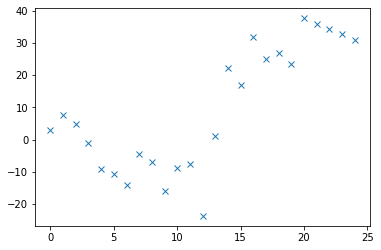

In [6]:
plt.plot(action_hist, 'x')

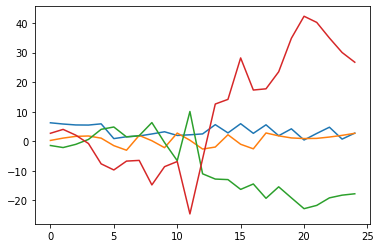

In [7]:
plt.plot(state_hist)

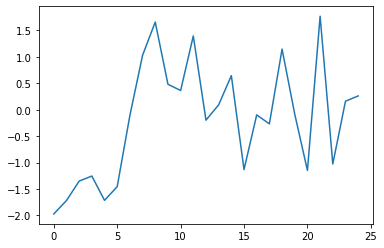

In [8]:
plt.plot(reward_hist)